# **Otimização de percurso no parque Magic Kingdom**

Trabalho final da disciplina de Organização e Planejamento

BI Master - PUC-Rio

Nome: Ana Paula Costa

Matrícula: 221100813

Turma: 2022.1



### **Introdução**
Uma viagem para visitar os parques da Disney em Orlando tem um custo financeiro alto e devido as grandes filas para as atrações, muitas vezes o passeio acaba sendo frustrante.
Atualmente são oferecidos aos visitantes comprar pacotes de fura fila para as atrações com valor adicional do ingresso do parque. Esses pacotes são caros e o objetivo desse estudo é otimizar a visita ao parque, sem a necessidade de adquirir pacotes de "fura fila", utilizando as filas padrão.

Algumas atrações possuem um tempo alto de espera nas filas e esse tempo de espera muda ao longo do dia.


**Objetivo**

O objetivo desse trabalho é a partir de uma lista de atrações desejadas a visitar no parque Magic Kingdom da Disney World, encontrar o melhor caminho a ser percorrido no parque priorizando menor tempo para o passeio.

Para isso utlizarei a seguir a implementação em algoritmos genéticos em Python, utilizando a bibilioteca DEAP.



**Observações**

Existem vários sites na internet que disponibilizam dados históricos dos tempos de fila das atrações dos parques ao longo dos dias, bem como previsões de tempo de espera para cada dia.
Como o objetivo desse trabalho não é realizar previsão de fila e sim otimizar o percurso através de algoritmos genéticos, será escolhido os dados de tempos de fila de um dia do mês de Julho de 2024 para a otimização. Uma possível evolução desse trabalho pode ser realizar a previsão de tempo de fila de cada atração ao longo do dia para ser utilizada como cálculo.

### **Obtenção dos Dados**



**THRILL DATA**

https://www.thrill-data.com/

Nesse site foi possivel obter tempo de fila para cada atração ao longo de um determinado dia do passado através de download de arquivos do tipo .csv contendo nome da atração, data e horario e tempo de espera


**APP MY DISNEY EXPERIENCE**

Através de consulta ao aplicativo de apoio aos parques da Disney World, foi possível montar um arquivo excel com o tempo de duração de cada atração e o tempo de descolamento entre uma atração e outra.

Esse mapeamento teve que ser feito manualmente, consultando o APP para uma informação mais precisa,  pois não existe API que forneça o tempo de trajeto entre uma atração e outra. O google maps não funciona bem para percursos dentro do parque.





## **Requisitos do problema**

Visitar as seguintes atrações no parque Magic Kingdom:
1. Tiana's Bayou Adventure
2. Seven Dwarfs Mine Train
3. TRON Lightcycle
4. Buzz Lightyear's Space Ranger Spin
5. Pirates of the Caribbean
6. Space Mountain
7. Haunted Mansion
8. Mickey's PhilharMagic
9. The Magic Carpets of Aladdin
10. Big Thunder Mountain Railroad
11. Jungle Cruise
12. Mad Tea Party
13. Dumbo the Flying Elephant
14. Under the Sea ~ Journey of The Little Mermaid
15. Peter Pan's Flight

Parar para almocar por 60 minutos em:

0. **Pinocchio Village Haus**

O passeio deve iniciar e terminar em:

16. **Main Entrance**

As seguintes restrições devem ser respeitadas:



*   A parada para almoco em **Pinocchio Village Haus** deve ocorrer entre a **5a** e **9a** posição do roteiro.
*   As atrações **Tiana's Bayou Adventure** (1) e **Big Thunder Mountain Railroad** (10) devem ocorrer uma antes ou depois da outra
*   As atrações **TRON Lightcycle** (3) e **Space Mountain** (6) devem ocorrer uma antes ou depois da outra







# **Implementação**

Instalação e carregamento das bibliotecas de GA em python

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.6 MB/s eta 0:00:00


Importação das bibliotecas utilizadas

In [ ]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import pandas as pd
import datetime

Variáveis fixas do ambiente

Será utilizado como referência os tempos de fila do sábado, dia 13 de julho de 2024.



In [ ]:
# Data que será utilizada como referência para obtenção dos tempos de fila
START_DATE_TIME = pd.to_datetime("2024-07-13 09:00:00")

# Local onde começa o percurso
MAIN_ENTRANCE = 16

Funções auxiliares para manupilação dos dados

In [ ]:
#Função que retorna o tempo de espera para um determinado horário
# Parametros recebidos
# df: Dataframe ordenado por hora contendo as colunas 'Date/Time' e 'Wait Time'
# date_time: data e hora no formato 'YYYY-MM-DD HH:MM:SS'
#
# Retorno: Tempo em minutos de espera na fila
def get_wait_time(df, date_time):
    if df is None or df.empty:
        return 0  # Retorna 0 se o dataframe estiver vazio

    # Converte date_time para datetime se necessário
    date_time = pd.to_datetime(date_time)

    # Converte a coluna 'Date/Time' para datetime se não estiver já convertida
    if df['Date/Time'].dtype != 'datetime64[ns]':
        df['Date/Time'] = pd.to_datetime(df['Date/Time'])

    # Localiza a linha que possui a menor diferença para a hora passada como parâmetro
    idx = (df['Date/Time'] - date_time).abs().idxmin()

    line = df.loc[idx]

    return line['Wait Time']


In [ ]:
# Função que le um arquivo csv e retorna um dataframe com os registros referentes a data passada como parametro.
#Parametros recebidos
#file_name: nome do arquivo .csv que deve conter a coluna 'Date/Time' e estar
#armazenado na sessão do notebook (/content/)
#date: data a ser pesquisada no formato 'YYYY-MM-DD HH:MM:SS'
#
#Retorno: dataframe ordenado pela data e contendo somente registros referentes
#a data (YYYY-MM-DD) passada como parametro
def read_csv(file_name, date):

    if pd.isna(file_name):  # Verificar se o nome do arquivo é nulo
        return None  # Retornar None se o nome do arquivo for nulo
    else:
      dfWaitTimes = pd.read_csv('/content/'+file_name)
      dfWaitTimes['Date/Time'] = pd.to_datetime(dfWaitTimes['Date/Time'])
      dfWaitTimes = dfWaitTimes[dfWaitTimes['Date/Time'].dt.date == pd.to_datetime(date).date()]
      dfWaitTimes = dfWaitTimes.sort_values('Date/Time')

    return dfWaitTimes

In [ ]:
# Função que retorna um dataframe contendo o plano de percurso no parque
# É muito similar a função objetivo
# Calcula o tempo total do trajeto no parque (incluindo paradas, tempo em fila,
# duração da atração e deslocamentos)
# e o tempo total gasto em deslocamentos.
# Retornos:
# dfRoutePlan: dataframe contendo o plano de percurso no parque
def getRoutePlan(individual):

  dfRoutePlan = pd.DataFrame()
  totalTime = 0
  totalWalkingTime = 0
  timeWalking = 0


  #A atração de origem é na Main Entrance, definida no início do código
  attraction = MAIN_ENTRANCE
  lastAttraction = MAIN_ENTRANCE

  #A hora de início do passeio será colocada como hora de saída da atração anterior
  #para a 1a iteração
  attrationDepartureTime = START_DATE_TIME
  arrivalTimeInLine = START_DATE_TIME

  #tempo de espera na fila - local de partida não tem espera
  attractionWaitTime = 0
  #duração da atração - local de partida não tem duração
  attractionDuration = 0


  new_row = pd.DataFrame({'Attraction': attractions['name'][attraction],
                          'id': attraction,
                          'Time walking': timeWalking,
                          'Arrival Time': arrivalTimeInLine,
                          'Wait Time': attractionWaitTime,
                          'Duration': attractionDuration,
                          'Departure Time': attrationDepartureTime,
                          'Next Attraction': attractions['name'][individual[0]],
                          'Id Next Attraction': individual[0],
                          'Total Time': totalTime,
                          'Total Walking Time': totalWalkingTime},index=[0] )

  dfRoutePlan = dfRoutePlan._append(new_row, ignore_index=True)

  #Agora começa o percurso
  # 1o gene é o 1o local a ser visitado
  for index, attraction in enumerate(individual):

    #Tempo gasto até a atração. Adiciona 3 pois a informação comeca na 3a coluna
    timeWalking = attractions.iloc[lastAttraction,attraction+3]

    #Hora de entrada na fila = Hora que saiu da atração anterior + tempo de deslocamento ate a atração
    arrivalTimeInLine = attrationDepartureTime + datetime.timedelta(minutes=int(timeWalking))

    #Tempo de espera na fila
    #Obtido pelo dataframe, coforme o horário de chegada na atração
    attractionWaitTime = get_wait_time(attractions['waitTimes'][attraction],arrivalTimeInLine)

    #Duração da atração
    attractionDuration = attractions['duration'][attraction]

    #Hora de saída da atração = Hora de Chegada na fila + Tempo em fila + Duração da atração
    attrationDepartureTime = arrivalTimeInLine + datetime.timedelta(minutes=int(attractionWaitTime)) + datetime.timedelta(minutes=int(attractionDuration))

    #Contador de tempo do trajeto
    totalTime = totalTime + timeWalking + attractionWaitTime + attractionDuration

    #Contador de tempo gasto em deslocamento
    totalWalkingTime = totalWalkingTime + timeWalking

    if index == len(individual) -1:
      nextAttraction = MAIN_ENTRANCE
    else:
      nextAttraction = individual[index+1]

    new_row = pd.DataFrame({'Attraction': attractions['name'][attraction],
                            'id': attraction,
                            'Time walking': timeWalking,
                            'Arrival Time': arrivalTimeInLine,
                            'Wait Time': attractionWaitTime,
                            'Duration': attractionDuration,
                            'Departure Time': attrationDepartureTime,
                            'Next Attraction': attractions['name'][nextAttraction],
                            'Id Next Attraction': nextAttraction,
                            'Total Time': totalTime,
                            'Total Walking Time': totalWalkingTime},index=[0] )

    dfRoutePlan = dfRoutePlan._append(new_row, ignore_index=True)


    # Atualiza a atração de origem para a próxima iteração
    lastAttraction = attraction

  #Saiu do loop, Percorreu todo o parque agora retorna para a posição de início.
  #Tempo gasto até a atração. Adiciona 3 pois a informação comeca na 3a coluna
  timeWalking = attractions.iloc[lastAttraction, nextAttraction+3]

  #Hora de entrada na fila = Hora que saiu da atração anterior + tempo de deslocamento ate a atração
  arrivalTimeInLine = attrationDepartureTime + datetime.timedelta(minutes=int(timeWalking))
  #Tempo de espera na fila = 0, , pois a ultima atração é a saída
  attractionWaitTime = 0
  #Duração da atração = 0, pois a ultima atração é a saída
  attractionDuration = 0
  #Hora de saída da atração = Hora de Chegada na fila + Tempo em fila + Duração da atração
  attrationDepartureTime = arrivalTimeInLine

  #Contador de tempo do trajeto
  totalTime = totalTime + timeWalking
  #Contador de tempo gasto em deslocamento
  totalWalkingTime = totalWalkingTime + timeWalking

  new_row = pd.DataFrame({'Attraction': attractions['name'][nextAttraction],
                          'id': nextAttraction,
                          'Time walking': timeWalking,
                          'Arrival Time': arrivalTimeInLine,
                          'Wait Time': attractionWaitTime,
                          'Duration': attractionDuration,
                          'Departure Time': attrationDepartureTime,
                          'Next Attraction': 'Home, Sweet Home',
                          'Id Next Attraction': None,
                          'Total Time': totalTime,
                          'Total Walking Time': totalWalkingTime},index=[0] )

  dfRoutePlan = dfRoutePlan._append(new_row, ignore_index=True)


  return dfRoutePlan

## Função de Penalização do indivíduo
Essa função verifica se o indívuo obedece as restrições para identificar se a penalização é necessária ou não.


In [ ]:
# Função de viabilidade do Indivíduo (Cromossoma)
# Retorna um fator de multiplicação a ser utlizado como penalização
#
# Os seguintes fatores serão retornados e acumulados caso ocorram:
#
# 20% de acréscimo:
# Caso a parada para almoco em Pinocchio Village Haus (0)
#   não ocorrer entre a 5a e 9a posição do roteiro.
#
# 10% de acréscimo:
# As atrações Tiana's Bayou Adventure (1) e Big Thunder Mountain Railroad (10)
#   não ocorrerem uma antes ou depois da outra
# 10% de acréscimo:
# As atrações TRON Lightcycle (3) e Space Mountain (6)
#   não ocorrerem uma antes ou depois da outra
def penalty(individual):
  penaltyFactor = 1

  zero_position = individual.index(0)
  three_position = individual.index(3)
  six_position = individual.index(6)
  one_position = individual.index(1)
  ten_position = individual.index(10)

  # 20% de acréscimo, caso a parada para almoço não ocorrer na posição estabelecida
  if zero_position < 4 or zero_position > 8:
    penaltyFactor = penaltyFactor + 0.20

  #10% de acréscimo, caso as atrações 3 e 6 não ocorrerem em sequência.
  if abs(three_position - six_position) != 1:
    penaltyFactor = penaltyFactor + 0.10

  #10% de acréscimo, caso as atrações 1 e 10 não ocorrerem em sequência.
  if abs(one_position - ten_position) != 1:
    penaltyFactor = penaltyFactor + 0.10

  return penaltyFactor

### Função Objetivo
Função que avalia o individuo

Para esse problema essa função recebe o individuo que é um vetor com a sequencia de atrações que devem ser percorridas e retorna duas avaliações que está se buscando a minimização:

- Tempo total gasto na visita do parque incluindo tempo de deslocamento, tempo em filas, tempo dentro da atração e tempo para almoço.

- Tempo gasto andando de uma atração para a outra.

In [ ]:
# Função Objetivo
# Calcula o tempo total do trajeto no parque (incluindo paradas, tempo em fila,
# duração da atração e deslocamentos)
# e o tempo total gasto em deslocamentos.
# Retornos:
# totalTime: Tempo total do percurso em minutos
# totalWalkingTime: Tempo total gasto em deslocamento.
def elapsed_time(individual):
  totalTime = 0
  totalWalkingTime = 0

  #A atração de origem é na Main Entrance, definida no início do código
  attraction = MAIN_ENTRANCE
  lastAttraction = MAIN_ENTRANCE

  #A hora de início do passeio será colocada como hora de saída da atração anterior
  #para a 1a iteração
  attrationDepartureTime = START_DATE_TIME

  #tempo de espera na fila - local de partida não tem espera
  attractionWaitTime = 0
  #duração da atração - local de partida não tem duração
  attractionDuration = 0

  #Agora começa o percurso
  # 1o gene é o 1o local a ser visitado
  for index, attraction in enumerate(individual):



    #Tempo gasto até a atração. Adiciona 3 pois a informação comeca na 3a coluna
    timeWalking = attractions.iloc[lastAttraction, attraction+3]

    #Hora de entrada na fila = Hora que saiu da atração anterior + tempo de deslocamento ate a atração
    arrivalTimeInLine = attrationDepartureTime + datetime.timedelta(minutes=int(timeWalking))

    #Tempo de espera na fila
    #Obtido pelo dataframe, coforme o horário de chegada na atração
    attractionWaitTime = get_wait_time(attractions['waitTimes'][attraction],arrivalTimeInLine)

    #Duração da atração
    attractionDuration = attractions['duration'][attraction]

    #Hora de saída da atração = Hora de Chegada na fila + Tempo em fila + Duração da atração
    attrationDepartureTime = arrivalTimeInLine + datetime.timedelta(minutes=int(attractionWaitTime)) + datetime.timedelta(minutes=int(attractionDuration))

    #Contador de tempo do trajeto
    totalTime = totalTime + timeWalking + attractionWaitTime + attractionDuration

    #Contador de tempo gasto em deslocamento
    totalWalkingTime = totalWalkingTime + timeWalking

    #Alcançou o final do roteiro, então Retorna para a entrada principal
    if index == len(individual) -1:
      nextAttraction = MAIN_ENTRANCE
    else:
      nextAttraction = individual[index+1]

    # Atualiza a atração de origem para a próxima iteração
    lastAttraction = attraction

  #Saiu do loop, Percorreu todo o parque agora retorna para a posição de início.
  #Tempo gasto até a atração. Adiciona 3 pois a informação comeca na 3a coluna
  timeWalking = attractions.iloc[lastAttraction, nextAttraction+3]

  #Hora de entrada na fila = Hora que saiu da atração anterior + tempo de deslocamento ate a atração
  arrivalTimeInLine = attrationDepartureTime + datetime.timedelta(minutes=int(timeWalking))
  #Tempo de espera na fila = 0, , pois a ultima atração é a saída
  attractionWaitTime = 0
  #Duração da atração = 0, pois a ultima atração é a saída
  attractionDuration = attractions['duration'][attraction]
  #Hora de saída da atração = Hora de Chegada na fila + Tempo em fila + Duração da atração
  attrationDepartureTime = arrivalTimeInLine

  #Contador de tempo do trajeto
  totalTime = totalTime + timeWalking
  #Contador de tempo gasto em deslocamento
  totalWalkingTime = totalWalkingTime + timeWalking

  #PENALIZAÇÃO
  totalTime = totalTime * penalty(individual)


  return totalTime, #totalWalkingTime

## Função de criação de Indivíduo

Cada indivíduo / cromossoma será representado por uma lista de 15 posições ordenada que indicará a ordem das atrações a serem percorridas no parque. Cada posição da lista é um gene e representa uma atração, através do seu id.
O 1o gene é a primeira atração a ser visitada, o 2o, a 2a e assim por diante.

A função de criação do indivíduo contem a lógica de restrições do percurso de forma a criar somente indivíduos válidos.




In [ ]:
# Função de criação do Indivíduo (Cromossoma)
# Retorna um indivíduo em forma de lista com 16 posições contendo
# números únicos de 0 a 15 que representam as atrações a serem percorridas (genes)
#
# As seguintes restrições são obedecidas na criação do indivíduo:
# A parada para almoco em Pinocchio Village Haus (0)
#   deve ocorrer entre a 5a e 9a posição do roteiro.
# As atrações Tiana's Bayou Adventure (1) e Big Thunder Mountain Railroad (10)
#   devem ocorrer uma antes ou depois da outra
# As atrações TRON Lightcycle (3) e Space Mountain (6)
#   devem ocorrer uma antes ou depois da outra
def create_individual():

    # Números possíveis de 0 a 15
    numbers = list(range(16))

    # Garante que o número 0 esteja nas posições 4 a 8, sorteando
    zero_position = random.randint(4, 8)
    # Cria uma lista vazia com 16 posições
    individual = [None] * 16

    # Coloca o número 0 na posição sorteada
    individual[zero_position] = 0
    #Remove o numero 0 da lista de numeros que podem ser escolhidos
    numbers.remove(0)

    # Escolhe posições aleatórias para os pares (3,6) e (1,10)
    # TRON Lightcycle (3) precisa estar antes ou depois de Space Mountain (6)
    # Tiana's Bayou Adventure (1) precisa estar antes ou depois de Big Thunder Mountain Railroad (10)
    for pair in [(3, 6), (1, 10)]:
        pair_choice = random.choice([list(pair), pair[::-1]])  # Escolhe a ordem do par
        pair_position = random.randint(0, 15)

        # Verifica se as posições escolhidas podem ser preenchidas
        while (individual[pair_position] is not None
               or pair_position + 1 >= len(individual)
               or individual[pair_position + 1] is not None):

            pair_position = random.randint(0, 15)

        # Coloca os números do par nas posições escolhidas
        individual[pair_position] = pair_choice[0]
        individual[pair_position + 1] = pair_choice[1]

        # Remove os números do par da lista de disponíveis
        numbers.remove(pair_choice[0])
        numbers.remove(pair_choice[1])

    # Preenche as posições restantes com números aleatórios
    for i in range(16):
        if individual[i] is None:
            num = random.choice(numbers)
            numbers.remove(num)
            individual[i] = num

    return individual

Carregamento do arquivo que contém as atrações desejadas, tempo gasto em minutos para andar de uma atração para a outra, e duração da atração.

In [ ]:
attractions = pd.read_excel('/content/mk_must_see_attractions.xlsx',na_values=['NA'],usecols="A:U",skiprows=0,header=1, index_col=0)
attractions

,name,duration,file,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
id,,,,,,,,,,,,,,,,,,,,
0,Pinocchio Village Haus,60,NaN,0,7,2,8,6,7,6,3,1,6,7,6,3,4,3,1,8
1,Tiana's Bayou Adventure,18,tianasbayouadventure.csv,7,0,8,12,9,4,11,6,6,4,2,4,9,11,10,6,10
2,Seven Dwarfs Mine Train,3,sevendwarfsminetrain.csv,2,8,0,6,4,8,5,4,2,7,9,7,1,3,3,3,8
3,TRON Lightcycle,1,tronlightcyclerun.csv,8,12,6,0,4,11,2,10,8,10,13,10,5,5,7,8,10
4,Buzz Lightyear's Space Ranger Spin,5,buzzlightyearsspacerangerspin.csv,6,9,4,4,0,8,3,7,5,6,10,7,4,5,6,6,7
5,Pirates of the Caribbean,15,piratesofthecaribbean.csv,7,4,8,11,8,0,10,6,7,2,5,2,8,10,10,6,8
6,Space Mountain,10,spacemountain.csv,6,11,5,2,3,10,0,9,6,8,12,9,4,5,6,7,9
7,Haunted Mansion,10,hauntedmansion.csv,3,6,4,10,7,6,9,0,3,4,6,5,5,7,6,2,8
8,Mickey's PhilharMagic,12,mickeysphilharmagic.csv,1,6,2,8,5,7,6,3,0,6,7,6,3,5,4,1,7


Carregamento dos tempos de espera para cada atração na data determinada.

In [ ]:
attractions['waitTimes'] = attractions.apply(lambda row: read_csv(row['file'], START_DATE_TIME), axis=1)

In [ ]:
attractions

,name,duration,file,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,waitTimes
id,,,,,,,,,,,,,,,,,,,,,
0,Pinocchio Village Haus,60,NaN,0,7,2,8,6,7,6,...,1,6,7,6,3,4,3,1,8,None
1,Tiana's Bayou Adventure,18,tianasbayouadventure.csv,7,0,8,12,9,4,11,...,6,4,2,4,9,11,10,6,10,Ride Date/T...
2,Seven Dwarfs Mine Train,3,sevendwarfsminetrain.csv,2,8,0,6,4,8,5,...,2,7,9,7,1,3,3,3,8,Ride Date/...
3,TRON Lightcycle,1,tronlightcyclerun.csv,8,12,6,0,4,11,2,...,8,10,13,10,5,5,7,8,10,Ride Date/Ti...
4,Buzz Lightyear's Space Ranger Spin,5,buzzlightyearsspacerangerspin.csv,6,9,4,4,0,8,3,...,5,6,10,7,4,5,6,6,7,Ride ...
5,Pirates of the Caribbean,15,piratesofthecaribbean.csv,7,4,8,11,8,0,10,...,7,2,5,2,8,10,10,6,8,Ride Date...
6,Space Mountain,10,spacemountain.csv,6,11,5,2,3,10,0,...,6,8,12,9,4,5,6,7,9,Ride Date/Time Wai...
7,Haunted Mansion,10,hauntedmansion.csv,3,6,4,10,7,6,9,...,3,4,6,5,5,7,6,2,8,Ride Date/Time Wa...
8,Mickey's PhilharMagic,12,mickeysphilharmagic.csv,1,6,2,8,5,7,6,...,0,6,7,6,3,5,4,1,7,Ride Date/Ti...


## Variação dos tempos de fila ao longo do tempo
Nos gráficos a seguir é possível visualizar um exemplo de como os tempos de espera das atrações variam ao longo do tempo.

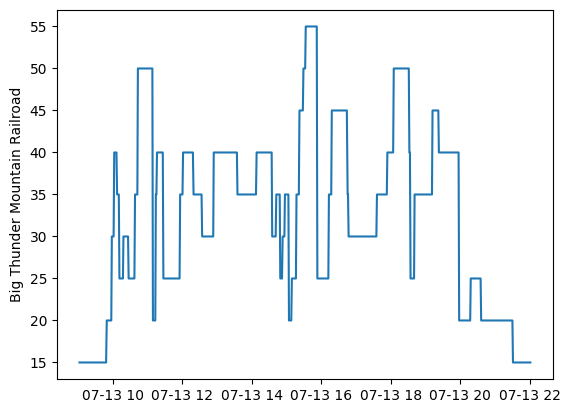

In [ ]:
dfWaitTimesExample = attractions['waitTimes'][10]

import matplotlib.pyplot as plt
plt.plot(dfWaitTimesExample['Date/Time'],dfWaitTimesExample['Wait Time'])
plt.ylabel('Big Thunder Mountain Railroad')
plt.show()


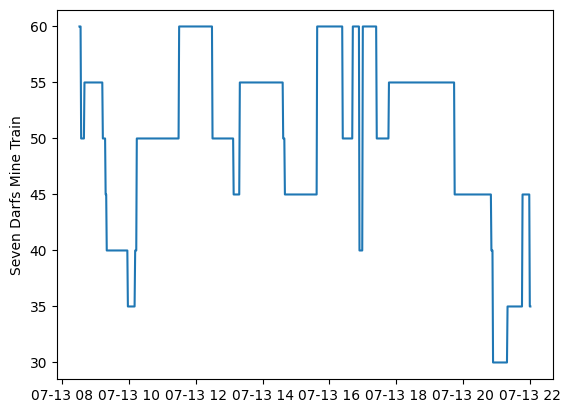

In [ ]:
dfWaitTimesExample = attractions['waitTimes'][2]
plt.plot(dfWaitTimesExample['Date/Time'],dfWaitTimesExample['Wait Time'])
plt.ylabel('Seven Darfs Mine Train')
plt.show()

### Declaração dos pacotes referentes a biblioteca DEAP do Algoritmno Genético:


In [ ]:
# Minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Definição do Toolbox

In [ ]:
toolbox = base.Toolbox()
# Registro da função que realiza a criação do indivíduo
toolbox.register("create_individual", create_individual)
# Inicialização do cromossomo
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.create_individual)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
toolbox.register("evaluate", elapsed_time)

#################################### OPERADORES ####################################
# Registro de qual o tipo de cruzamento para problemas de ordem
toolbox.register("mate", tools.cxOrdered)
# Registro de qual tipo de mutação deve ser utilizado
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
# Registro de qual o tipo do método de seleção que será utilizado, torneio
toolbox.register("select", tools.selTournament, tournsize=5)

## Chamada efetiva do GA para resolução

In [ ]:
pop = toolbox.population(n=400)                           # inicialização da pop
hof = tools.HallOfFame(1)                                 # melhor indivíduo
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=80, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min	max
0  	400   	732.008	48.7276	616	884
1  	308   	758.659	106.983	598	1258.6
2  	304   	737.151	107.948	590	1223.6
3  	286   	724.94 	114.268	583	1226.4
4  	319   	726.522	115.868	579	1141.2
5  	301   	719.332	116.68 	573	1272.7
6  	303   	700.607	116.717	568	1179.1
7  	318   	703.498	115.027	568	1247.4
8  	311   	687.731	111.607	563	1246  
9  	314   	672.912	106.174	554	1073.8
10 	320   	658.521	94.952 	554	1162  
11 	324   	675.13 	113.529	554	1134  
12 	313   	663.222	100.994	554	1233.4
13 	309   	655.953	102.424	547	1119.3
14 	305   	645.638	103.809	550	1037.4
15 	315   	642.037	97.9586	550	966   
16 	318   	618.336	95.2372	548	1024.4
17 	325   	616.541	97.0233	547	1029  
18 	316   	606.467	85.0188	547	924.3 
19 	317   	618.567	100.945	547	1138.2
20 	332   	601.396	87.7892	545	1033.5
21 	322   	603.439	99.3577	540	1061.2
22 	309   	595.241	88.744 	540	1055.6
23 	323   	592.083	89.77  	540	1050  
24 	301   	591.377	94.1998	540	1084.8
25 	314   	594.308

## Resultados

In [ ]:
bestIndividual = hof[0]

Plano de Rota do melhor indivíduo.

In [ ]:
getRoutePlan(bestIndividual)

,Attraction,id,Time walking,Arrival Time,Wait Time,Duration,Departure Time,Next Attraction,Id Next Attraction,Total Time,Total Walking Time
0,Main Entrance,16,0,2024-07-13 09:00:00,0,0,2024-07-13 09:00:00,Jungle Cruise,11,0,0
1,Jungle Cruise,11,8,2024-07-13 09:08:00,1,8,2024-07-13 09:17:00,Big Thunder Mountain Railroad,10,17,8
2,Big Thunder Mountain Railroad,10,5,2024-07-13 09:22:00,15,7,2024-07-13 09:44:00,Tiana's Bayou Adventure,1,44,13
3,Tiana's Bayou Adventure,1,2,2024-07-13 09:46:00,26,18,2024-07-13 10:30:00,TRON Lightcycle,3,90,15
4,TRON Lightcycle,3,12,2024-07-13 10:42:00,35,1,2024-07-13 11:18:00,Space Mountain,6,138,27
5,Space Mountain,6,2,2024-07-13 11:20:00,30,10,2024-07-13 12:00:00,Buzz Lightyear's Space Ranger Spin,4,180,29
6,Buzz Lightyear's Space Ranger Spin,4,3,2024-07-13 12:03:00,15,5,2024-07-13 12:23:00,Mickey's PhilharMagic,8,203,32
7,Mickey's PhilharMagic,8,5,2024-07-13 12:28:00,15,12,2024-07-13 12:55:00,Pinocchio Village Haus,0,235,37
8,Pinocchio Village Haus,0,1,2024-07-13 12:56:00,0,60,2024-07-13 13:56:00,Dumbo the Flying Elephant,13,296,38
9,Dumbo the Flying Elephant,13,4,2024-07-13 14:00:00,5,2,2024-07-13 14:07:00,Haunted Mansion,7,307,42


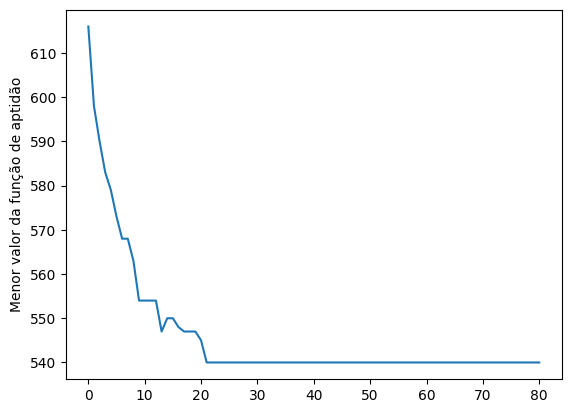

In [ ]:
import matplotlib.pyplot as plt
gen, minVal = log.select("gen", "min")
plt.plot(gen, minVal)
plt.ylabel('Menor valor da função de aptidão')
plt.show()